# Read in CMIP6 output, integrate regionally, generate derived variables, and calculate seasonal climatologies

Start with [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) magic; this reloads modules automatically before entering the execution of code and thus enabled development in modules like [util.py](util.py).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt

import util

import intake

## Connect to catalog

This notebook uses an [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) to describe file locations. This is the basis of [intake-esm](https://intake-esm.readthedocs.io/en/latest/), though here we are not using `intake-esm` directly.

In [3]:
cat = intake.open_esm_datastore(util.catalog_json)
cat

,unique
activity_id,17
institution_id,35
source_id,81
experiment_id,130
member_id,421
table_id,36
variable_id,1075
grid_label,12
dcpp_init_year,59
version,595


In [4]:
%%time
df = pd.read_csv(util.catalog_csv)
df

CPU times: user 5.93 s, sys: 341 ms, total: 6.27 s
Wall time: 6.35 s


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path
0,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
1,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r1i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
2,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
3,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r2i1p1f1,day,tasmax,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
4,AerChemMIP,BCC,BCC-ESM1,ssp370-lowNTCF,r3i1p1f1,day,rsds,gn,NaN,v20190624,20150101-20551231,/glade/collections/cmip/CMIP6/AerChemMIP/BCC/B...
...,...,...,...,...,...,...,...,...,...,...,...,...
2303253,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r1i1p1f1,6hrLev,va,gn,NaN,v20190625,209803010000-209803311800,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
2303254,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r1i1p1f1,6hrLev,va,gn,NaN,v20190625,209804010000-209804301800,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
2303255,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r1i1p1f1,Oday,tos,gn,NaN,v20210329,20150101-20641231,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...
2303256,ScenarioMIP,MRI,MRI-ESM2-0,ssp585,r1i1p1f1,Oday,tos,gn,NaN,v20210329,20650101-21001231,/glade/collections/cmip/CMIP6/gcm/ScenarioMIP/...


In [5]:
cat.search(institution_id="NIMS-KMA").df.source_id.unique()

array(['UKESM1-0-LL', 'KACE-1-0-G'], dtype=object)

## Specify a subset of models

In [6]:
models = [
    'CanESM5',
    # 'CanESM5-CanOE', # only epc100 found
    'CNRM-ESM2-1', 
    'ACCESS-ESM1-5',  # crashing with clobber=T?
    'MPI-ESM-1-2-HAM', 
    'IPSL-CM6A-LR',
    'MPI-ESM1-2-HR',
    'MPI-ESM1-2-LR',  
    'NorCPM1', # not plotting bc no areacello
    'NorESM2-LM', 
    'UKESM1-0-LL',
    'MIROC-ES2L', 
    'MRI-ESM2-0',
    'CESM2', # no fgo2 but adding to compare CO2
]
## others on ESGF showing historical+Omon+fgo2 = EC-Earth3-CC, GFDL-CM4, GFDL-ESM4, IPSL-CM5A2-INCA, IPSL-CM6A-LR-INCA, NorESM2-MM (but of the above ESGF not showing CNRM-ESM2-1, UKESM1-0-LL, MIROC-ES2L, MRI-ESM2-0)


In [7]:
instituion_ids = {}
for m in models:
    instituion_ids[m] = list(cat.search(source_id=m).df.institution_id.unique())
    
instituion_ids    

{'CanESM5': ['CCCma'],
 'CNRM-ESM2-1': ['CNRM-CERFACS'],
 'ACCESS-ESM1-5': ['CSIRO'],
 'MPI-ESM-1-2-HAM': ['HAMMOZ-Consortium'],
 'IPSL-CM6A-LR': ['IPSL'],
 'MPI-ESM1-2-HR': ['MPI-M', 'DKRZ', 'DWD'],
 'MPI-ESM1-2-LR': ['MPI-M'],
 'NorCPM1': ['NCC'],
 'NorESM2-LM': ['NCC'],
 'UKESM1-0-LL': ['NIMS-KMA', 'MOHC'],
 'MIROC-ES2L': ['MIROC'],
 'MRI-ESM2-0': ['MRI'],
 'CESM2': ['NCAR']}

### Test read single model

In [8]:
source_id = 'UKESM1-0-LL'
variable_id = ['sos']
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4

dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)
dsi

UKESM1-0-LL, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 6 ensemble members


<xarray.Dataset>
Dimensions:             (time: 120, bnds: 2, j: 330, i: 360, vertices: 4, member_id: 4)
Coordinates:
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 ...
    longitude           (j, i) float32 ...
  * member_id           (member_id) <U8 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 2005-01-01 00:00:00 ... 2015-01-0...
    vertices_latitude   (j, i, vertices) float32 ...
    vertices_longitude  (j, i, vertices) float32 ...
    sos                 (member_id, time, j, i) float32 nan nan nan ... nan nan
Attributes: (12/43)
    history:                 2019-06-24T12:18:13Z ; CMOR rewrote data to be c...
    cv_version:              6.2.20.1
    experiment_id:           historical
    grid:                    Native eORCA1 tripolar primarily 1 deg with meri...
    table_id:                Omon
    title:                   UKESM1-0-LL output prepared for CMIP6
    ...                      ...
    experiment:              all-forcing simulation of the recent past
    license:                 CMIP6 model data produced by the Met Office Hadl...
    institution_id:          MOHC
    Conventions:             CF-1.7 CMIP-6.2
    cmor_version:            3.4.0
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

### Test calculating derived variables

In [9]:
source_id = 'UKESM1-0-LL'
#source_id = 'MRI-ESM2-0'
#variable_name = 'fgn2:sos,tos,hfds'
#variable_name = 'fgo2_thermal:sos,tos,hfds'
variable_name = 'fgapo:fgo2,fgco2,sos,tos,hfds'
time_slice = slice('2005', '2014')
experiment_id = 'historical' 
nmax_members = 4
models_flipsign = util.get_models_flipsign(['fgco2', 'fgn2', 'fgo2'])

print(variable_name)
variable_id = variable_name
derived_var = variable_name
if ':' in variable_id:
    variable_id = variable_name.split(':')[-1].split(',')
    derived_var = variable_name.split(':')[0]        
    print(variable_id)
    print(derived_var)
                
dsi = util.open_cmip_dataset(
    source_id=source_id, 
    variable_id=variable_id, 
    experiment_id=experiment_id, 
    time_slice=time_slice, 
    table_id='Omon',
    nmax_members=nmax_members,
)

# compute derived variables
if derived_var == 'fgn2':
    dsi = util.compute_fgn2(dsi)

elif derived_var == 'fgo2_thermal':
    dsi = util.compute_fgo2_thermal(dsi)

elif derived_var == 'fgapo':
    o2scale = -1.0 if source_id in models_flipsign['fgo2'] else 1.0 # needed here bc NorESM2-LM O2 is flipped
    co2scale = -1.0 if source_id in models_flipsign['fgco2'] else 1.0
    n2scale = -1.0 if source_id in models_flipsign['fgn2'] else 1.0
    dsi = util.compute_fgapo(dsi, o2scale, co2scale, n2scale)
    
dsi

fgapo:fgo2,fgco2,sos,tos,hfds
['fgo2', 'fgco2', 'sos', 'tos', 'hfds']
fgapo
UKESM1-0-LL, historical, ['fgo2', 'fgco2', 'sos', 'tos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 16 ensemble members


<xarray.Dataset>
Dimensions:             (member_id: 4, time: 120, bnds: 2, j: 330, i: 360, vertices: 4)
Coordinates:
  * member_id           (member_id) <U9 'r1i1p1f2' 'r2i1p1f2' ... 'r4i1p1f2'
  * time                (time) object 2005-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 -84.11 -84.11 -84.11 ... 50.23 50.01
    longitude           (j, i) float32 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
    depth               float64 0.0
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 2005-01-01 00:00:00 ... 2015-01-0...
    vertices_latitude   (j, i, vertices) float32 -84.16 -84.16 ... 50.0 50.11
    vertices_longitude  (j, i, vertices) float32 73.0 74.0 74.0 ... 73.0 73.0
    fgco2               (member_id, time, j, i) float32 nan nan nan ... nan nan
    fgo2                (member_id, time, j, i) float32 nan nan nan ... nan nan
    hfds                (member_id, time, j, i) float32 nan nan nan ... nan nan
    sos                 (member_id, time, j, i) float32 nan nan nan ... nan nan
    tos                 (member_id, time, j, i) float32 nan nan nan ... nan nan
    fgn2                (member_id, time, j, i) float32 nan nan nan ... nan nan
    fgapo               (member_id, time, j, i) float32 nan nan nan ... nan nan
Attributes: (12/45)
    history:                 2019-12-05T11:36:40Z ; CMOR rewrote data to be c...
    experiment_id:           historical
    grid:                    Native eORCA1 tripolar primarily 1 deg with meri...
    table_id:                Omon
    title:                   UKESM1-0-LL output prepared for CMIP6
    mip_era:                 CMIP6
    ...                      ...
    license:                 CMIP6 model data produced by the Met Office Hadl...
    institution_id:          MOHC
    Conventions:             CF-1.7 CMIP-6.2
    cmor_version:            3.4.0
    realization_index:       9
    intake_esm_dataset_key:  CMIP.MOHC.UKESM1-0-LL.historical.Omon.gn

## Get grid data from each model

Skip models where the grid data is not available

In [10]:
dsets_fix = {}
grid_variables = ['areacello',]
for model in models:
    dsets_m = [util.get_gridvar(df, model, v) for v in grid_variables]
    dsets_m = [ds for ds in dsets_m if ds is not None]
    if dsets_m:
        dsets_fix[model] = xr.merge(dsets_m)
        dsets_fix[model].attrs['source_id'] = model
        
list(dsets_fix.keys())

NorCPM1: missing "areacello"


/glade/u/home/stephens/miniconda3/envs/sno/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


['CanESM5',
 'CNRM-ESM2-1',
 'ACCESS-ESM1-5',
 'MPI-ESM-1-2-HAM',
 'IPSL-CM6A-LR',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'NorESM2-LM',
 'UKESM1-0-LL',
 'MIROC-ES2L',
 'MRI-ESM2-0',
 'CESM2']

## Compute a region mask for integration

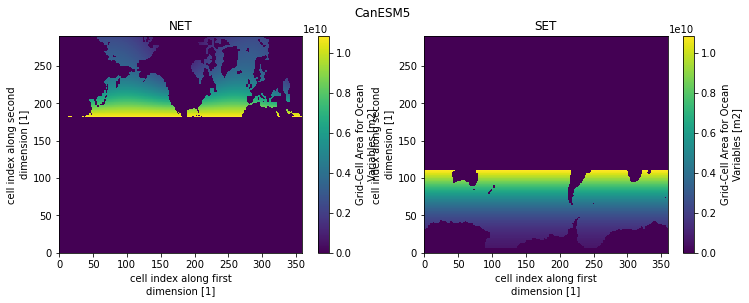

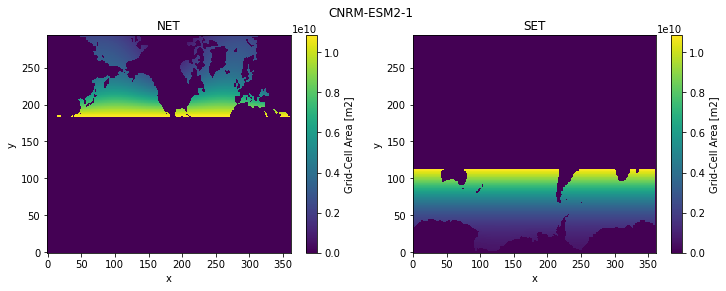

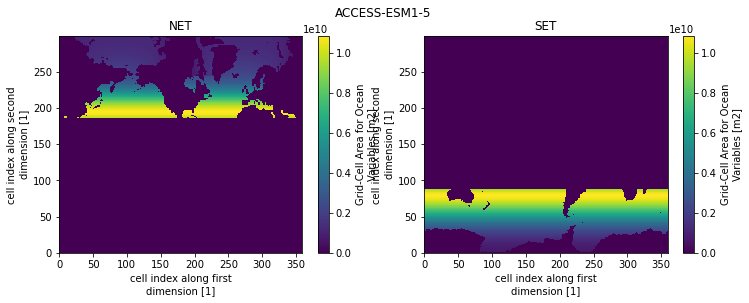

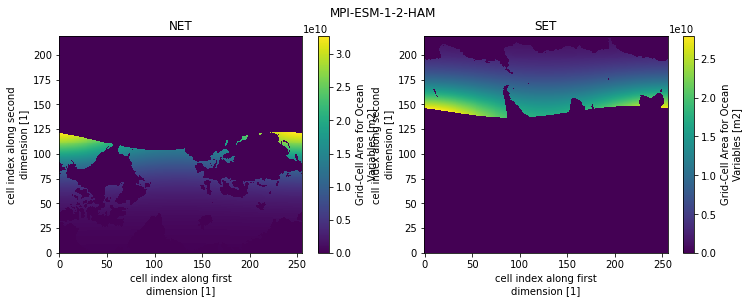

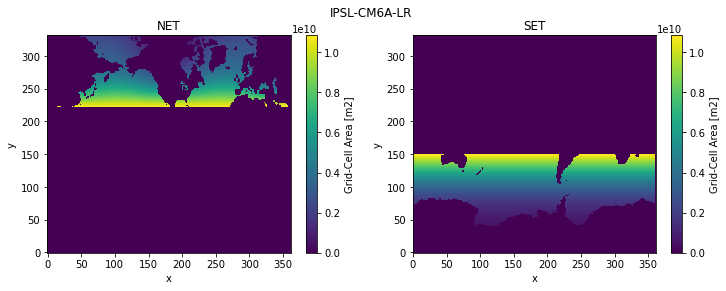

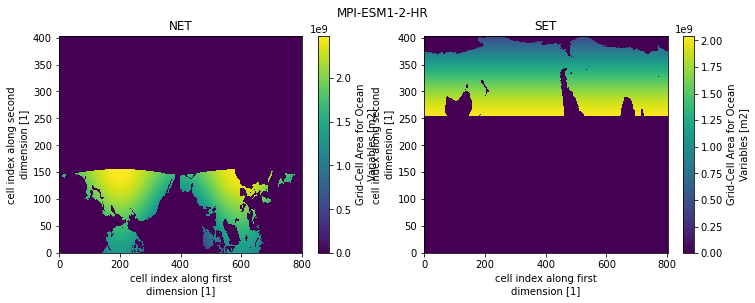

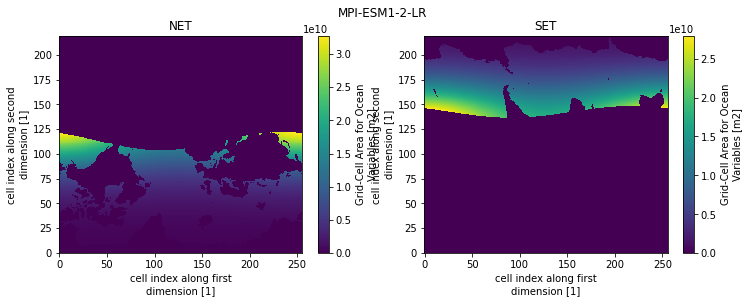

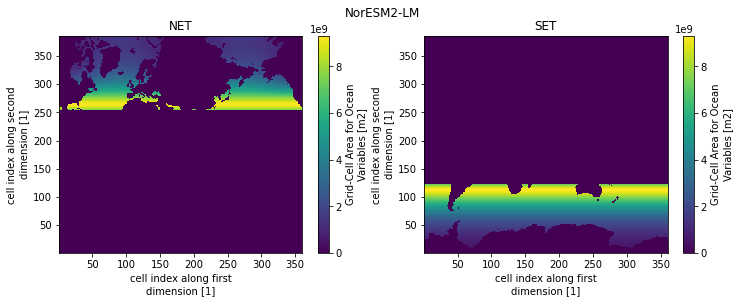

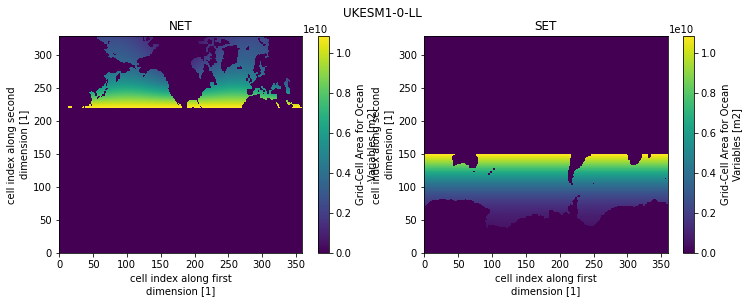

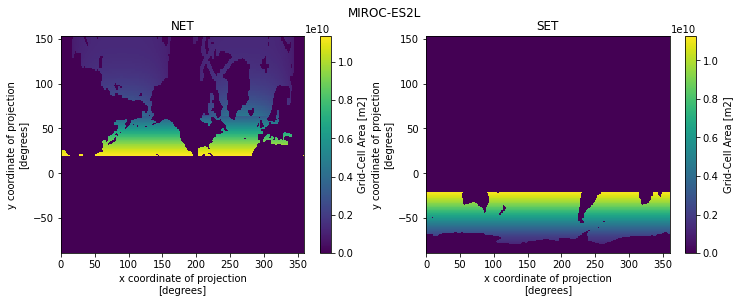

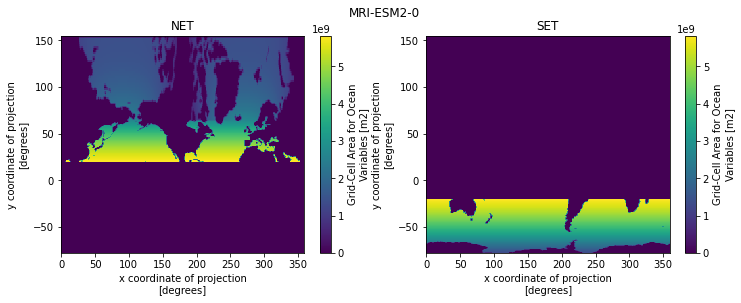

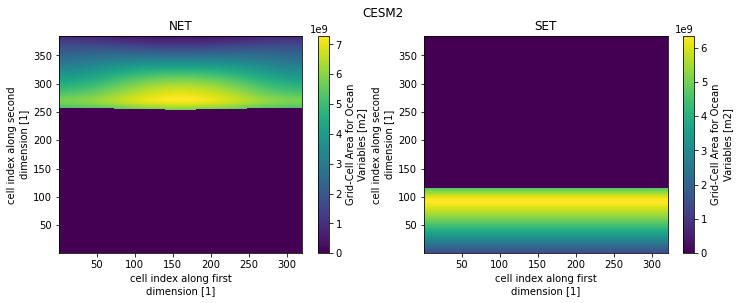

In [11]:
rmask_definition = 'SET_NET' # poleward of 20
#rmask_definition = 'SHL_NHL' # poleward of 45
#rmask_definition = 'global' ### grid-cell area is maxing at 20 degrees in each hemisphere

rmask_dict = {}
for model in models:    
    if model not in dsets_fix:
        continue
    rmask_dict[model] = util.get_rmask_dict(
        dsets_fix[model], 
        mask_definition=rmask_definition, 
        plot=True
    )    

## Assemble monthly-mean climatology

This code takes the following steps:
- Read a dataset for each model
- Compute the regional integral 
- Compute the mean for each month and average across ensemble members
- Concatenate the resulting timeseries along a `source_id` dimension

Note that the code is set up to cache the resulting dataset; it will optionally read this dataset, rather than recreate it, if it exists.

## fix coordinates

Some files for some variable have differences in the coordinates that hinder merging. 

Define a function to pass in as a `preprocess` to fix the coordinates on each dataset before the merge. 

In [12]:
from toolz import curry
@curry
def fix_grid(ds, ds_fix, replace_vars):
    for v in replace_vars:
        ds[v] = ds_fix[v]
    return ds

preprocess = {source_id: None for source_id in models}

if 'ACCESS-ESM1-5' in models:
    preprocess["ACCESS-ESM1-5"] = fix_grid(
        ds_fix=dsets_fix["ACCESS-ESM1-5"],
        replace_vars=["latitude", "longitude"],
    )
    
preprocess

{'CanESM5': None,
 'CNRM-ESM2-1': None,
 'ACCESS-ESM1-5': <function fix_grid at 0x2ab36b4d07a0>,
 'MPI-ESM-1-2-HAM': None,
 'IPSL-CM6A-LR': None,
 'MPI-ESM1-2-HR': None,
 'MPI-ESM1-2-LR': None,
 'NorCPM1': None,
 'NorESM2-LM': None,
 'UKESM1-0-LL': None,
 'MIROC-ES2L': None,
 'MRI-ESM2-0': None,
 'CESM2': None}

In [32]:
%%time
variable_ids = [
    'intpp', 
    'fgco2', 
    'fgo2', 
    'tos', 
    'sos',
    'hfds',
    'fbddtdic',
    'epc100',
    'fgn2:tos,sos,hfds',
    'fgo2_thermal:tos,sos,hfds',
    'fgapo:fgo2,fgco2,tos,sos,hfds',
]

clobber = False
    
time_slice = slice("2005", "2014") ## for comparison to HIPPO/ORCAS/ATom 2009-2018, pick closest decade

experiment_id = 'historical' 
table_id = 'Omon'
nmax_members = 4

# specify models for each variable that have reverse sign convention
models_flipsign = util.get_models_flipsign(variable_ids)

missing_data = util.missing_data_tracker()
if clobber:
    missing_data.clobber() ### this crashed when clobber = True

# initialize a dictionary to keep track of attributes
# that can get clobbered on xarray merge/concatentate operations
variable_attrs = util.track_attrs()
    
ds_list = []
source_id_list = []

catalog_out_entries = []
for source_id in models:    
    if source_id not in rmask_dict:
        continue
        
    ds_list_variable_ids = []
    for variable_name in variable_ids:
        
        variable_id, search_vars = util.id_and_search_vars(variable_name)
        
        cache_file = (
            f'data/cache/cmip/cmip6'
            f'.{source_id}'
            f'.{experiment_id}'
            f'.{variable_id}'
            f'.{rmask_definition}'
            f'.monclim_{time_slice.start}-{time_slice.stop}.zarr'
        )
        catalog_out_entry = dict(
            source_id=source_id, 
            variable_id=variable_id, 
            experiment_id=experiment_id, 
            table_id=table_id,
            time_start=time_slice.start, 
            time_stop=time_slice.stop, 
            nmax_members=nmax_members,
            region_mask=rmask_definition,
            operator_applied="regional_integral",
            path=f"{os.getcwd()}/{cache_file}",
        )          
        
        if os.path.exists(cache_file) and not clobber:
            ds = xr.open_zarr(cache_file)
            catalog_out_entries.append(catalog_out_entry)
        else:
            # see if this is missing
            missing_search = missing_data.ismissing(
                source_id=source_id, 
                experiment_id=experiment_id, 
                table_id=table_id,
            )

            if any(missing_search(variable_id=v) for v in search_vars):
                dsi = None
            
            else:
                
                dsi = util.open_cmip_dataset(
                    source_id=source_id, 
                    variable_id=search_vars, 
                    experiment_id=experiment_id, 
                    table_id=table_id,
                    time_slice=time_slice, 
                    nmax_members=nmax_members,
                    preprocess=preprocess[source_id],
                )
            
                # check to ensure all variables are present
                if dsi is None or not all(v in dsi for v in search_vars):
                    print(f'missing data: {source_id}, {experiment_id}')                
                    for v in search_vars:
                        if dsi is None or v not in dsi:
                            print(f'\t{v}')
                            missing_data.set_missing(
                                source_id=source_id, 
                                variable_id=v, 
                                experiment_id=experiment_id, 
                                table_id=table_id,
                            )
                    dsi = None
                
            if dsi is None:
                # generate missing values dataset
                ds = xr.Dataset({
                    variable_id: xr.DataArray(
                        np.ones((len(rmask_dict[source_id]), 12)) * np.nan,
                        dims=('region', 'month'),
                        name=variable_id,
                    )
                })
                
            else:
                # compute derived variables
                if variable_id == 'fgn2':
                    dsi = util.compute_fgn2(dsi)

                elif variable_id == 'fgo2_thermal':
                    dsi = util.compute_fgo2_thermal(dsi)   
                    
                elif variable_id == 'fgapo':
                    o2scale = -1.0 if source_id in models_flipsign['fgo2'] else 1.0 # needed here bc NorESM2-LM O2 is flipped
                    co2scale = -1.0 if source_id in models_flipsign['fgco2'] else 1.0
                    n2scale = -1.0 if source_id in models_flipsign['fgn2'] else 1.0
                    dsi = util.compute_fgapo(dsi, o2scale, co2scale, n2scale)

                # copy attrs for later 
                variable_attrs.update_attrs(
                    variable_id, 
                    dsi[variable_id].attrs, 
                    clobber=clobber,
                )
                    
                # compute the regional integrals
                flipsign = True if source_id in models_flipsign[variable_id] else False            
                da = util.compute_regional_integral(
                    ds=dsi, 
                    variable_id=variable_id,
                    rmasks=rmask_dict[source_id],
                    flipsign=flipsign,
                )    
    
                with xr.set_options(keep_attrs=True):
                    da = da.groupby('time.month').mean().mean('member_id')

                if 'depth' in da.coords:
                    da = da.drop(['depth'])
                
                ds = da.to_dataset().compute()              

                ds.to_zarr(cache_file, mode='w', consolidated=True);            
                         
        ds_list_variable_ids.append(ds)
    
    if ds_list_variable_ids:
        source_id_list.append(source_id)

    # merge across variables
    if ds_list_variable_ids:
        ds_list.append(xr.merge(ds_list_variable_ids,))

missing_data.persist()        
        
print('final merge')
ds = xr.concat(ds_list, 
               dim=xr.DataArray(
                   source_id_list, dims=('source_id'), name='source_id'),
              )    

# put back the attrs
for var_id in ds.data_vars:
    if not ds[var_id].attrs:
        ds[var_id].attrs = variable_attrs[var_id]

ACCESS-ESM1-5, historical, ['intpp']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
ACCESS-ESM1-5, historical, ['fgco2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
ACCESS-ESM1-5, historical, ['fgo2']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
ACCESS-ESM1-5, historical, ['tos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 3 ensemble members
ACCESS-ESM1-5, historical, ['sos']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 40 ensemble members
ACCESS-ESM1-5, historical, ['hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 40 ensemble members
ACCESS-ESM1-5, historical, ['epc100']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 40 ensemble members
ACCESS-ESM1-5, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 40 ensemble members
ACCESS-ESM1-5, historical, ['tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 40 ensemble members
ACCESS-ESM1-5, historical, ['fgo2', 'fgco2', 'tos', 'sos', 'hfds']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


	found 40 ensemble members
final merge
CPU times: user 30min 18s, sys: 8min 10s, total: 38min 28s
Wall time: 48min 56s


In [33]:
dfo = pd.DataFrame(catalog_out_entries)
dfo

,source_id,variable_id,experiment_id,table_id,time_start,time_stop,nmax_members,region_mask,operator_applied,path
0,CanESM5,intpp,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
1,CanESM5,fgco2,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
2,CanESM5,fgo2,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
3,CanESM5,tos,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
4,CanESM5,sos,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
...,...,...,...,...,...,...,...,...,...,...
97,CESM2,hfds,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
98,CESM2,fbddtdic,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
99,CESM2,epc100,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...
100,CESM2,fgn2,historical,Omon,2005,2014,4,SET_NET,regional_integral,/glade/u/home/stephens/SNO/sno-analysis/notebo...


In [34]:
import json
with open(util.catalog_json) as fid:
    catalog_dict = json.load(fid)

    
catalog_dict["description"] = "catalog of local cache files"
catalog_dict["catalog_file"] = util.cache_catalog_csv

parent_attrs = {d["column_name"]: d for d in catalog_dict["attributes"]}
attributes_dicts = []
for c in dfo.columns:
    if c in parent_attrs:
        attributes_dicts.append(parent_attrs[c])
    else:
        attributes_dicts.append({"column_name": c})
catalog_dict["attributes"] = attributes_dicts
attribute_names = [d["column_name"] for d in attributes_dicts]

catalog_dict["assets"] = {"column_name": "path", "format": "zarr"}
catalog_dict["aggregation_control"]["groupby_attrs"] = [
    "experiment_id", 
    "table_id",
    "region_mask",
    "operator_applied",
]
aggregations = list(catalog_dict["aggregation_control"]["aggregations"])

catalog_dict["aggregation_control"]["aggregations"] = [d for d in aggregations if d["attribute_name"] in attribute_names]
catalog_dict["aggregation_control"]["aggregations"].extend([
    {'type': 'join_new', 'attribute_name': 'source_id'},
])
    
dfo.to_csv(util.cache_catalog_csv)
with open(util.cache_catalog_json, "w") as fid:
    json.dump(catalog_dict, fid)

catalog_dict    

{'esmcat_version': '0.1.0',
 'id': 'glade-cmip6',
 'last_updated': '2022-01-05T21:29:26Z',
 'description': 'catalog of local cache files',
 'catalog_file': 'catalogs/cmip6-process-cache.csv.gz',
 'attributes': [{'column_name': 'source_id',
   'vocabulary': 'https://raw.githubusercontent.com/WCRP-CMIP/CMIP6_CVs/master/CMIP6_source_id.json'},
  {'column_name': 'variable_id', 'vocabulary': ''},
  {'column_name': 'experiment_id',
   'vocabulary': 'https://raw.githubusercontent.com/WCRP-CMIP/CMIP6_CVs/master/CMIP6_experiment_id.json'},
  {'column_name': 'table_id',
   'vocabulary': 'https://raw.githubusercontent.com/WCRP-CMIP/CMIP6_CVs/master/CMIP6_table_id.json'},
  {'column_name': 'time_start'},
  {'column_name': 'time_stop'},
  {'column_name': 'nmax_members'},
  {'column_name': 'region_mask'},
  {'column_name': 'operator_applied'},
  {'column_name': 'path'}],
 'assets': {'column_name': 'path', 'format': 'zarr'},
 'aggregation_control': {'variable_column_name': 'variable_id',
  'groupby_a

## test catalog

In [35]:
dsets = util.open_cmip_cached("regional_integral", "SET_NET")
ds2 = dsets['historical.Omon.SET_NET.regional_integral']
ds2


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.table_id.region_mask.operator_applied'


<xarray.Dataset>
Dimensions:       (source_id: 11, region: 2, month: 12)
Coordinates:
  * source_id     (source_id) <U15 'CESM2' 'CNRM-ESM2-1' ... 'UKESM1-0-LL'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) <U3 'NET' 'SET'
Data variables:
    epc100        (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fbddtdic      (source_id, region, month) float32 dask.array<chunksize=(3, 2, 12), meta=np.ndarray>
    fgapo         (source_id, region, month) float32 dask.array<chunksize=(2, 2, 12), meta=np.ndarray>
    fgco2         (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgn2          (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgo2          (source_id, region, month) float32 dask.array<chunksize=(2, 2, 12), meta=np.ndarray>
    fgo2_thermal  (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    hfds          (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    intpp         (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    sos           (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    tos           (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
Attributes:
    intake_esm_varname:      epc100\nfbddtdic\nfgapo\nfgco2\nfgn2\nfgo2\nfgo2...
    intake_esm_dataset_key:  historical.Omon.SET_NET.regional_integral

## Make some plots

In [36]:
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

In [37]:
# define function to plot 4 variables (columns) by 2 regions (rows)

def plot4var2reg(variable_ids):

    nrows = 2
    ncols = len(variable_ids)
    
    #ncols = 4
    #nrows = np.ceil(len(variable_ids)*len(ds.region.values)/ncols).astype(int)
    #for region, field, ax in zip(np.repeat(ds.region.values,len(variable_ids)), variable_ids*len(ds.region.values), axs.ravel()):

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) # , sharey=True)

    for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
        for counter,source_id in enumerate(ds.source_id.values):
            if counter < 10:
                mk='o'
            else:
                mk='x'
            ax.plot(
                ds.month-0.5, 
                ds[field].sel(source_id=source_id, region=region), 
                marker=mk, 
                linestyle='-',
                label=source_id,
                #color=plt.rcParams['axes.prop_cycle'].by_key()['color'][counter%10]
            )

        ax.set_xticks(np.arange(13))    
        ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
        ax.set_title(region);
        ax.set_xticklabels([])
        ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
    ax.legend(loc=(1.02, 0));

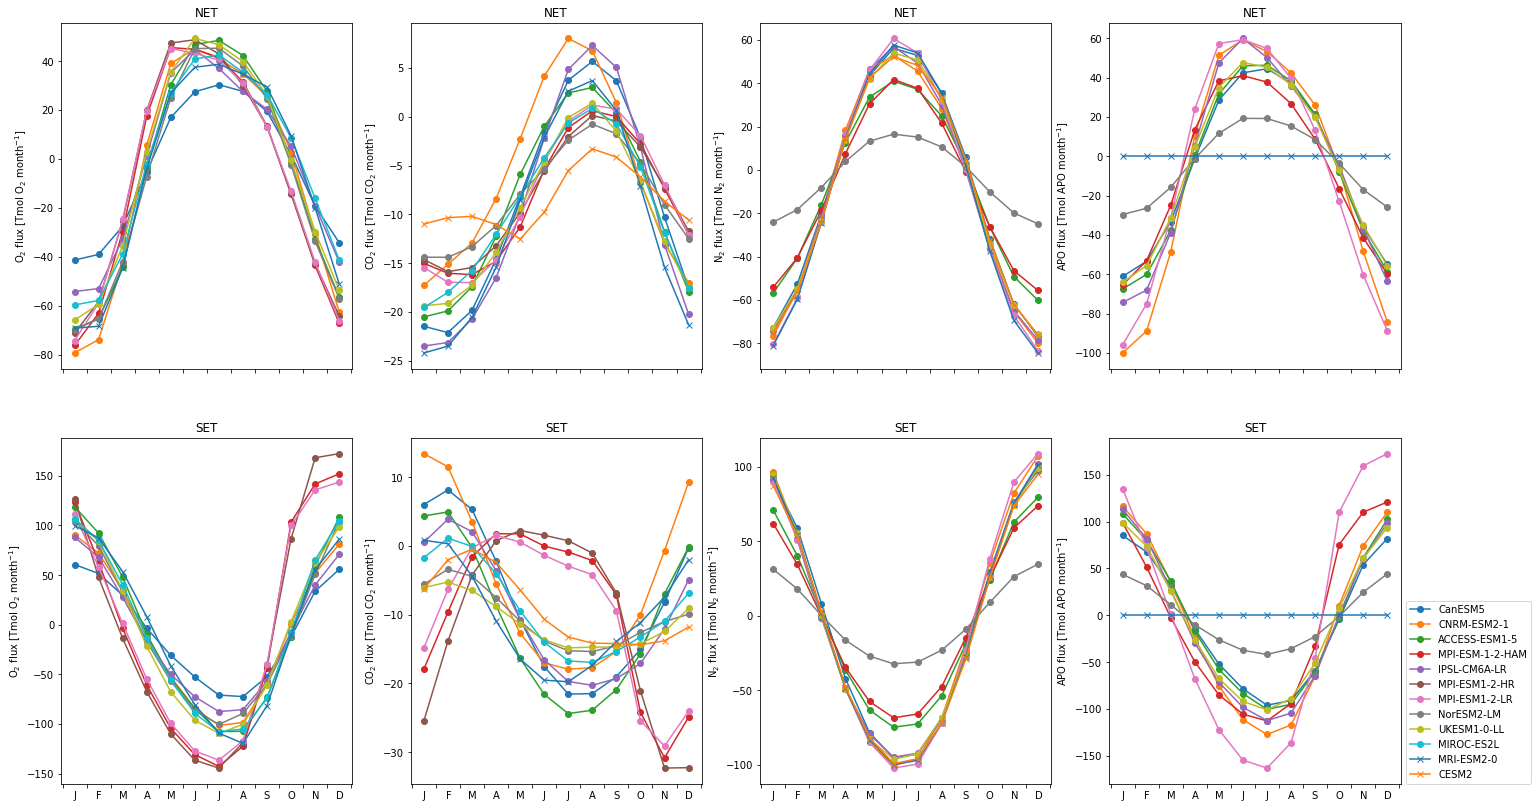

In [38]:
variable_ids = ['fgo2','fgco2','fgn2','fgapo']
plot4var2reg(variable_ids)

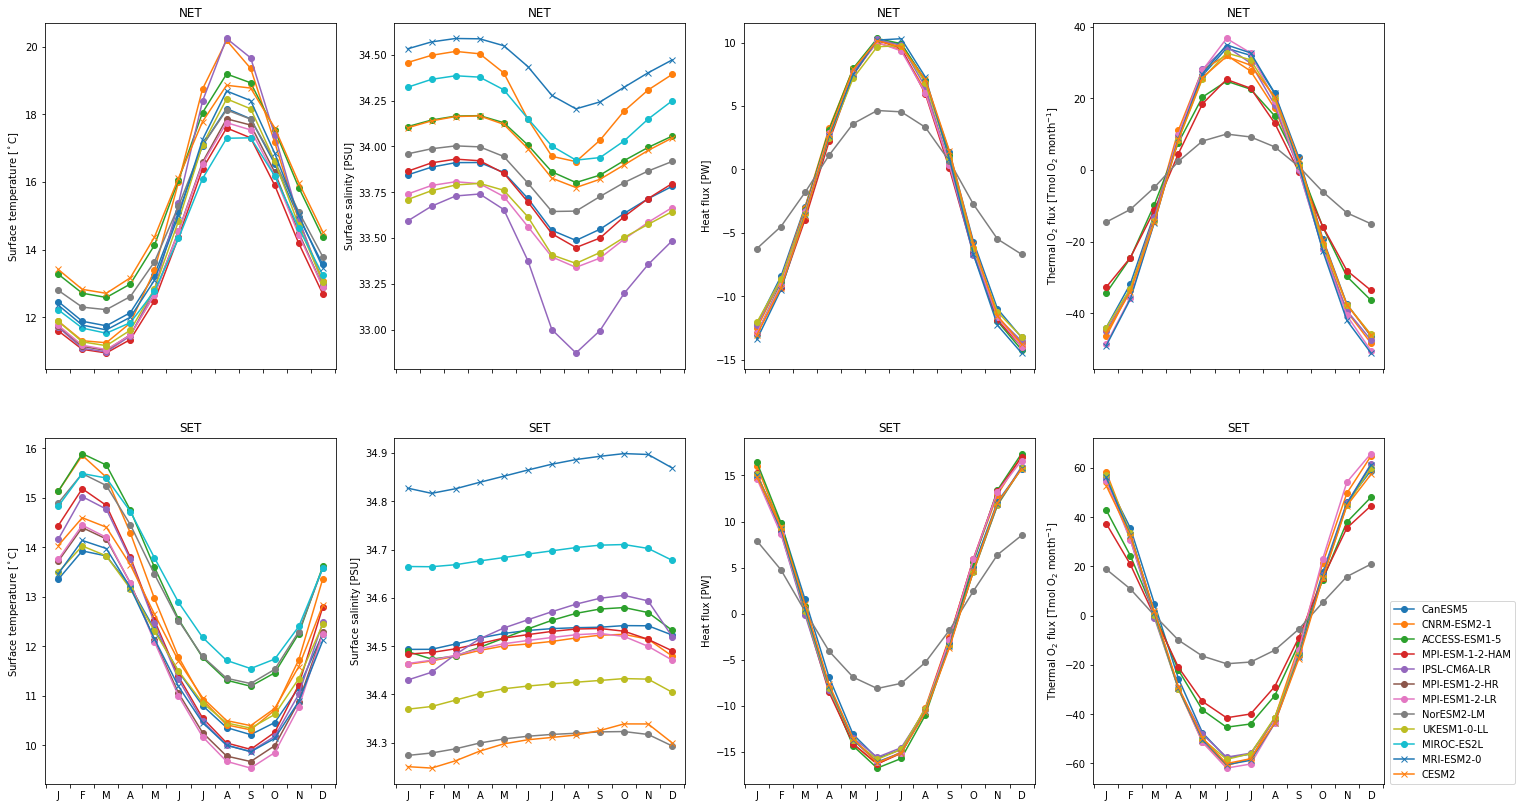

In [39]:
variable_ids = [ 'tos', 'sos', 'hfds','fgo2_thermal' ]
plot4var2reg(variable_ids)

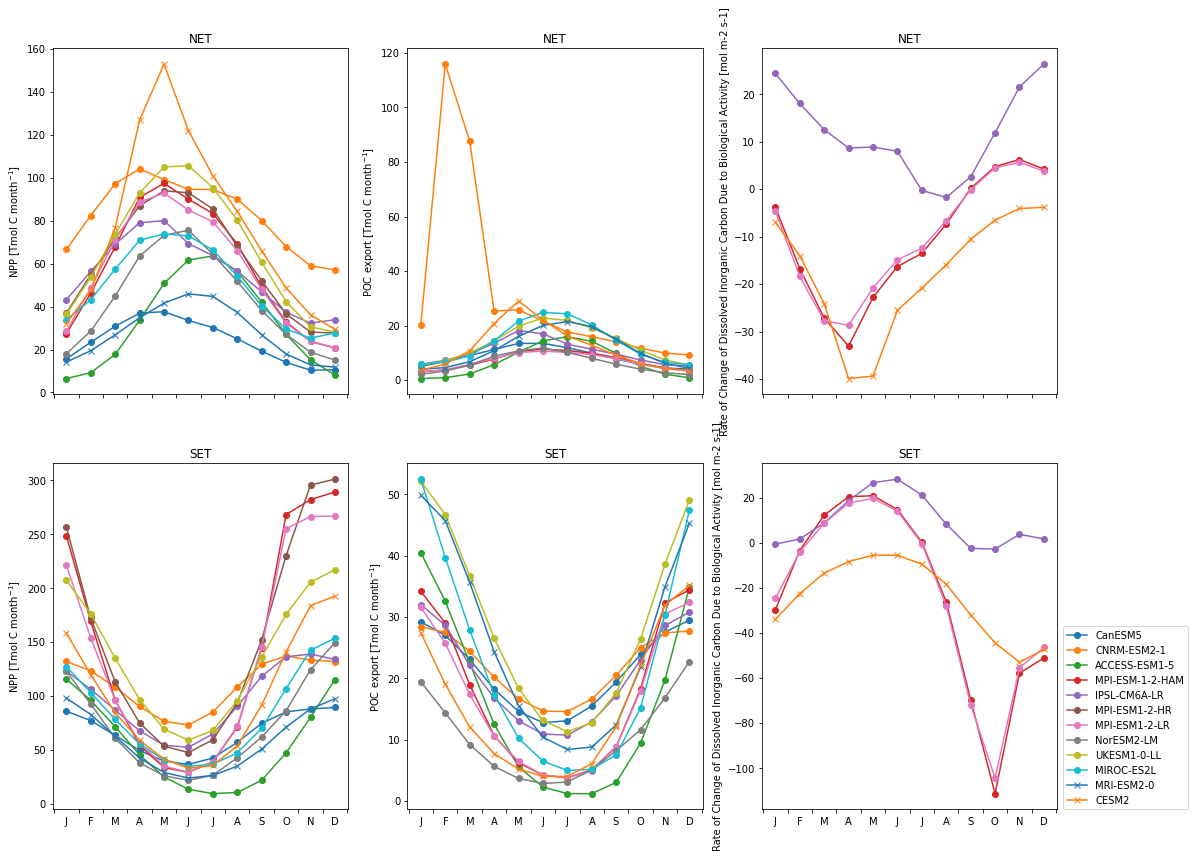

In [40]:
variable_ids = [ 'intpp', 'epc100', 'fbddtdic']
plot4var2reg(variable_ids)

In [41]:
# list all models in catalog
cat.df.source_id.unique()

array(['BCC-ESM1', 'CNRM-ESM2-1', 'MPI-ESM-1-2-HAM', 'MIROC6',
       'MRI-ESM2-0', 'CESM2-WACCM', 'CESM2', 'NorESM2-LM', 'UKESM1-0-LL',
       'GFDL-ESM4', 'BCC-CSM2-MR', 'CanESM5', 'CMCC-ESM2',
       'ACCESS-ESM1-5', 'EC-Earth3-CC', 'IPSL-CM6A-LR', 'MIROC-ES2L',
       'MPI-ESM1-2-LR', 'GISS-E2-1-G', 'TaiESM1', 'AWI-CM-1-1-MR',
       'AWI-ESM-1-1-LR', 'CAMS-CSM1-0', 'FGOALS-f3-L', 'FGOALS-g3',
       'IITM-ESM', 'CanESM5-CanOE', 'CMCC-CM2-HR4', 'CMCC-CM2-SR5',
       'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'ACCESS-CM2', 'E3SM-1-0',
       'EC-Earth3-AerChem', 'EC-Earth3-LR', 'EC-Earth3-Veg-LR',
       'EC-Earth3-Veg', 'EC-Earth3', 'FIO-ESM-2-0', 'INM-CM4-8',
       'INM-CM5-0', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR-INCA', 'KIOST-ESM',
       'MIROC-ES2H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'ICON-ESM-LR',
       'MPI-ESM1-2-HR', 'GISS-E2-1-G-CC', 'GISS-E2-1-H', 'CESM2-FV2',
       'CESM2-WACCM-FV2', 'NorCPM1', 'NorESM1-F', 'NorESM2-MM',
       'KACE-1-0-G', 'GFDL-AM4', 'GFDL-CM4', 'NESM3', 'SA

In [42]:
# list all models that include historical Omon fgo2
tmp = cat.search(experiment_id='historical', table_id='Omon', grid_label='gn', variable_id='fgo2')
tmp.df.source_id.unique()

array(['CanESM5', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'MPI-ESM-1-2-HAM',
       'IPSL-CM6A-LR', 'MIROC-ES2L', 'UKESM1-0-LL', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'NorESM2-LM'],
      dtype=object)